# Set parameters for the experiment

In [1]:
exp_name = '20210702_LGK_Ctrl'

tracking_name = 'Spots in tracks statistics_scaffold_2_AW_20210813.csv'
ld_roi_name = 'RoiSet_dead_cells_only_yellow.zip'

out_path = 'Z:/CellTracking/Final/Analyzed data/LGK'

#Get image pixel sizes from the drift_corrected image
corrected_dimensions = [512,513]
xy_scaling = 1
minutes_per_frame=2
z_step = 1

#Crypt-villus borders
dmz = [30,33]

# Import packages

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
from IPython.display import clear_output
import seaborn as sbn
import sys
import os
#Location for custom scripts
root = 'C'
root = '/mnt/{}'.format(root.lower()) if os.getcwd().startswith('/mnt') else '{}:'.format(root)
sys.path.append('{}/Users/karlan/Google Drive/Python/Projects/Anna'.format(root))

from cell_tracking_basic_v1 import *
from cell_tracking_plotting_v1 import *

# Specify names and locations

In [4]:
root = 'Z'
root = '/mnt/{}'.format(root.lower()) if os.getcwd().startswith('/mnt') else '{}:'.format(root)
path = '{}/CellTracking/Final/Basic data'.format(root)

tracked_cells_path = os.path.join(path, exp_name, tracking_name)
ld_path = os.path.join(path, exp_name, ld_roi_name)

# Read in data

In [5]:
cell_df_raw = pd.read_csv(tracked_cells_path, index_col = 0)
cell_df_raw = cell_df_raw.loc[cell_df_raw['TRACK_ID']!='None']

## Correct for pixel scaling, if it's incorrect

In [6]:
if xy_scaling == 1:
    for col in ['POSITION_X','POSITION_Y']:
        cell_df_raw[col] = cell_df_raw[col]*1.405
    xy_scaling = 1.405
        
if z_step==1:
    cell_df_raw['POSITION_Z'] = cell_df_raw['POSITION_Z']*2.5
    z_step = 2.5

## Continue analysis

In [7]:
cell_df_raw = correct_measurements(cell_df_raw, image_pixel_size = corrected_dimensions, minutes_per_frame=minutes_per_frame, xy_scaling = xy_scaling)

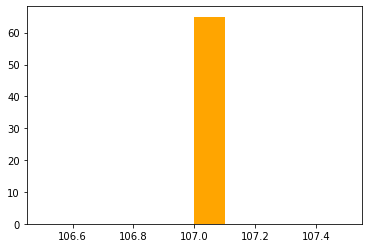

In [8]:
fig, ax = plt.subplots(1)

# Remove tracks that are shorter than a fraction of longest frames

cell_df = filter_tracks(cell_df_raw, fraction_of_max = 1.1, inplace = False)

ax.hist(cell_df_raw['TRACK_ID'].value_counts(), color = 'gray')
ax.hist(cell_df['TRACK_ID'].value_counts(), color = 'orange', alpha=1)
plt.show()

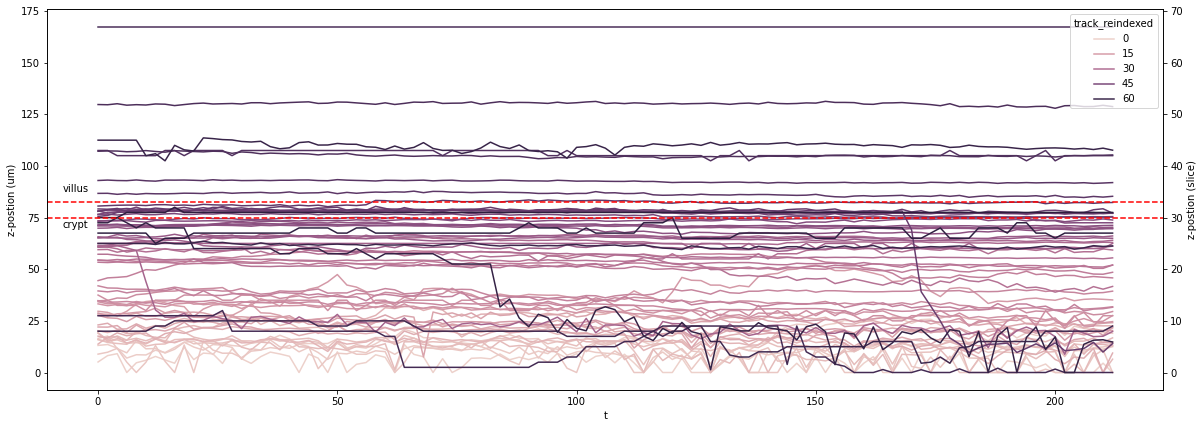

In [9]:
fig, ax = plt.subplots(figsize = (20, 7))
sbn.lineplot(data = cell_df, x = 't', y = 'z', hue = 'track_reindexed', ax = ax)
[ax.axhline(x*z_step, color = 'red', ls = '--') for x in dmz]
[ax.text(x = -2, y = x*z_step-5-(10*-ix), s = ['crypt', 'villus'][ix], ha = 'right') for ix, x in enumerate(dmz)]
ax.set_ylabel('z-postion (um)')
ax2 = ax.twinx()
ax2.set_ylim(np.array(ax.get_ylim())/z_step)
ax2.set_ylabel('z-postion (slice)')

classify_z(cell_df, z_step = z_step, dmz = dmz)

(0.0, 212.0)

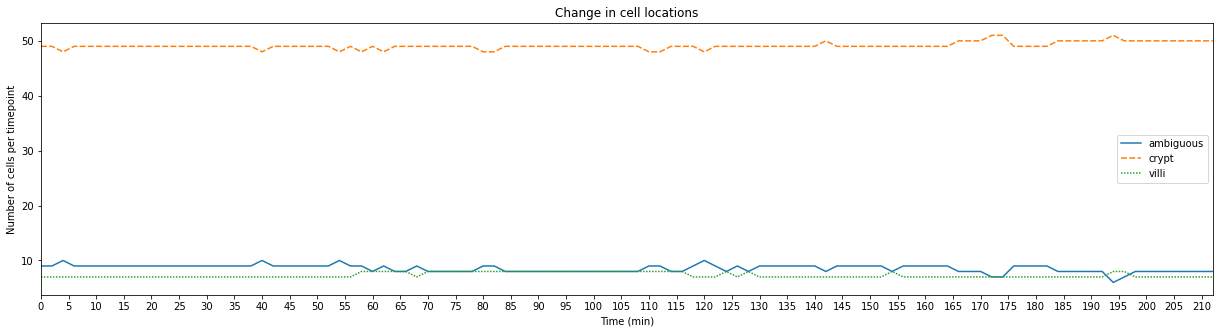

In [10]:
class_df = pd.DataFrame(index = ['ambiguous','crypt','villi'], columns = sorted(set(cell_df['t'].values)))
for t in sorted(set(cell_df['t'].values)):
    class_df[t] = cell_df[cell_df['t'] == t]['z_class'].value_counts()

fig, ax = plt.subplots(figsize = (21,5))
sbn.lineplot(data = class_df.T)
plt.xlabel('Time (min)')
plt.ylabel('Number of cells per timepoint')
plt.title('Change in cell locations')
plt.xticks(np.arange(0,max(cell_df['t'])+5, 5))
plt.xlim([0,max(cell_df['t'])])

#plt.savefig(path + 'Change in cell locations pooled for each timepoint.pdf', format = 'pdf')

In [11]:
calculate_cell_movement(cell_df)

class_dict = {'villi': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              'crypt': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              'ambiguous': (1.0, 0.4980392156862745, 0.054901960784313725)}

track_ending_z_dict = {}
track_ending_color_dict = {}
track_starting_color_dict = {}
for track in set(cell_df['track_reindexed']):
    val_end = cell_df[cell_df['track_reindexed']==track]['z_class'].iloc[-1]
    val_start = cell_df[cell_df['track_reindexed']==track]['z_class'].iloc[0]
    track_ending_z_dict[track] = val_end
    track_ending_color_dict[track] = class_dict[val_end]
    track_starting_color_dict[track] = class_dict[val_start]

# Plot live/dead 

Importing coordinates...
Plotting


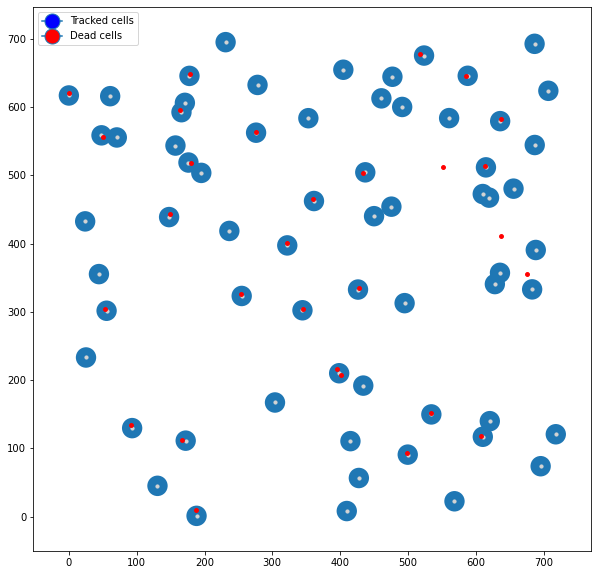

Classifying...


C:\Users\karlan\AppData\Local\Continuum\anaconda3\envs\anna\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
live_dead_import_plot_classify(ld_path, cell_df, cell_radius = 15, s = 10, xy_drift = (0, 0), corrected_dimensions = corrected_dimensions, xy_scaling = xy_scaling)

In [14]:
class_df_live = pd.DataFrame(index = ['ambiguous','crypt','villi'], columns = sorted(set(cell_df['t'].values)))
for t in sorted(set(cell_df['t'].values)):
    class_df_live[t] = cell_df[(cell_df['t'] == t)&(cell_df['Live_dead']=='Alive')]['z_class'].value_counts()
    
class_df_dead = pd.DataFrame(index = ['ambiguous','crypt','villi'], columns = sorted(set(cell_df['t'].values)))
for t in sorted(set(cell_df['t'].values)):
    class_df_dead[t] = cell_df[(cell_df['t'] == t)&(cell_df['Live_dead']=='Dead')]['z_class'].value_counts()

### Plot absolute number of alive or dead cells per compartment

Text(0.5, 1.0, 'Dead cells')

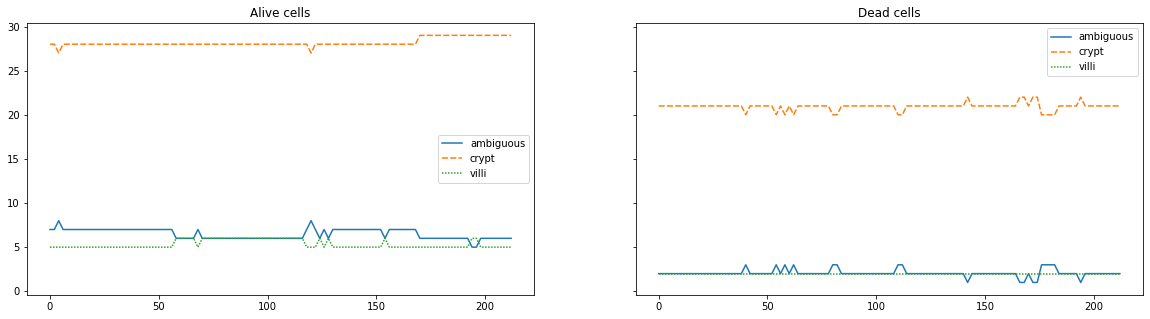

In [15]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,5), sharey = True)
sbn.lineplot(data = class_df_live.T, ax = axes[0])
axes[0].set_title('Alive cells')
sbn.lineplot(data = class_df_dead.T, ax = axes[1])
axes[1].set_title('Dead cells')


### Plot percentages of alive or dead cells per compartment

Text(0.5, 1.0, 'Dead cells')

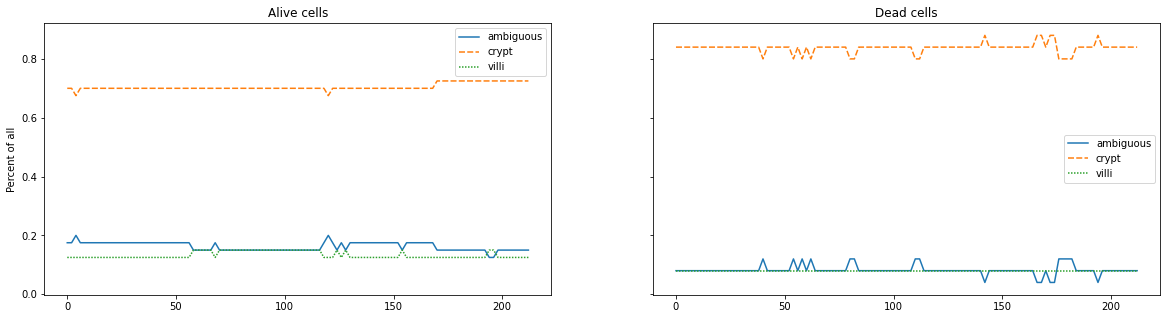

In [16]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,5), sharey = True)
sbn.lineplot(data = class_df_live.T.div(class_df_live.sum(axis = 0), axis = 0), ax = axes[0])
axes[0].set_title('Alive cells')
axes[0].set_ylabel('Percent of all')
sbn.lineplot(data = class_df_dead.T.div(class_df_dead.sum(axis = 0), axis = 0), ax = axes[1])
axes[1].set_title('Dead cells')

# Cell z_movement summary 

C:\Users\karlan\AppData\Local\Continuum\anaconda3\envs\anna\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\karlan\AppData\Local\Continuum\anaconda3\envs\anna\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\karlan\AppData\Local\Continuum\anaconda3\envs\anna\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\karlan\AppData\Local\Continuum\anaconda3\envs\anna\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


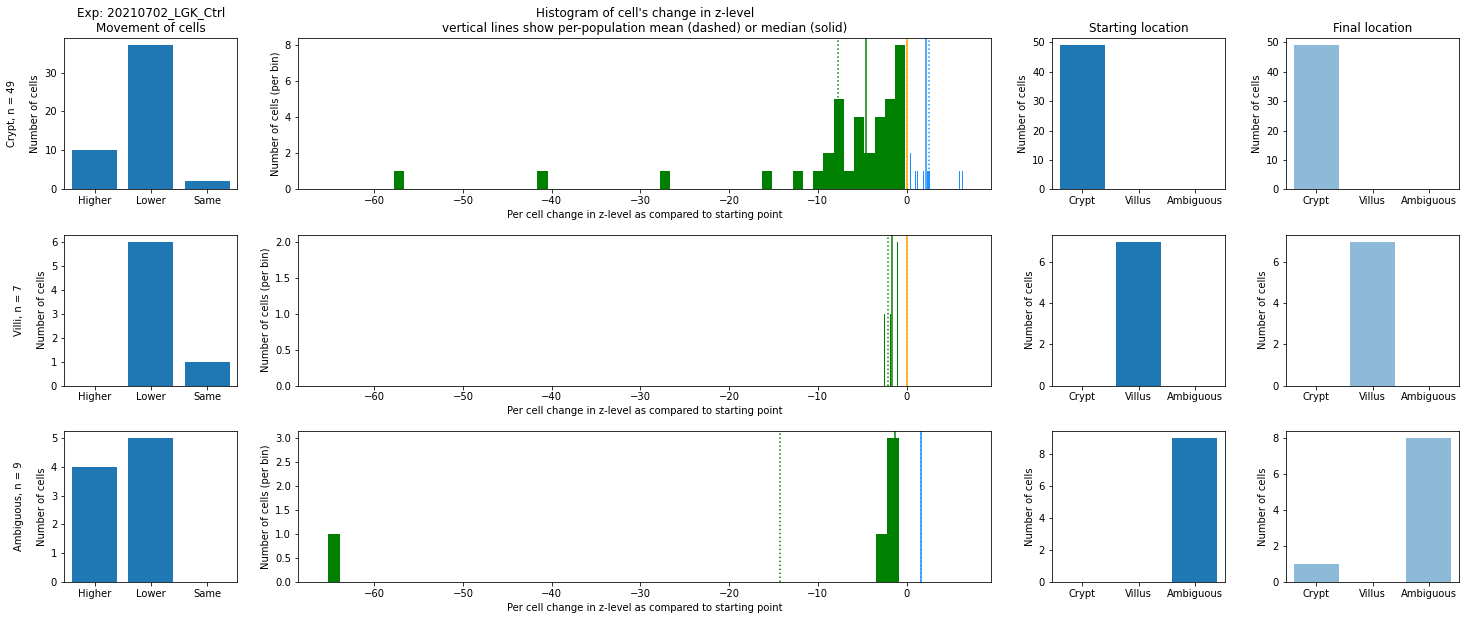

In [17]:
plot_cell_z_movements(cell_df, nrows = 3, ncols = 4, plot_percentage = False, hist_xlim = True, return_fig = False, experiment_name=exp_name)

# Movements of cells per timepoint

## Average speed for each track according to compartment (average xy-distance travelled between timepoints)

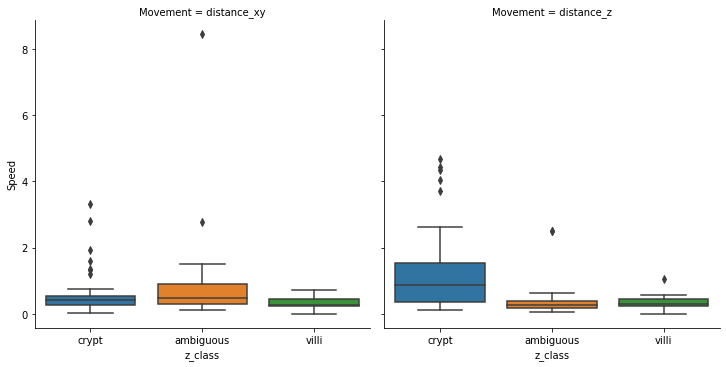

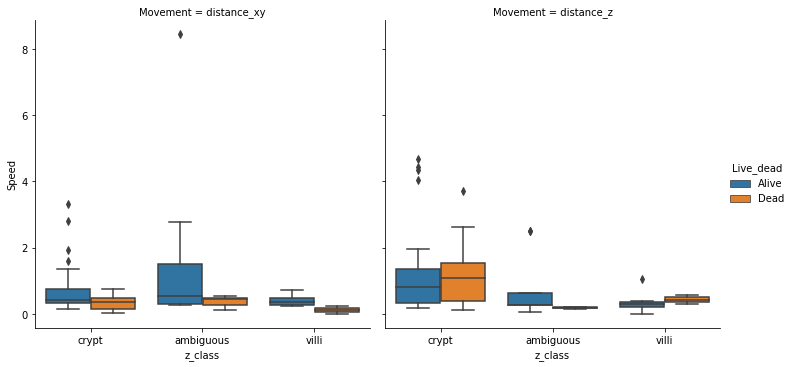

In [18]:
tmp = cell_df.groupby(['z_class','track_reindexed', 'Live_dead'])[['distance_xy', 'distance_z']].mean().reset_index()
tmp = pd.melt(tmp, id_vars=['z_class', 'Live_dead'], value_vars=['distance_xy', 'distance_z'], var_name='Movement', value_name='Speed')
sbn.catplot(data = tmp, y = 'Speed', x = 'z_class', kind = 'box', col='Movement', order=['crypt','ambiguous','villi'])
sbn.catplot(data = tmp, y = 'Speed', x = 'z_class', hue = 'Live_dead', kind = 'box', col='Movement', order=['crypt','ambiguous','villi'], hue_order = ['Alive','Dead'])

#### Look at only between 0 and 10 on the y axis (the one outlier was really out there)

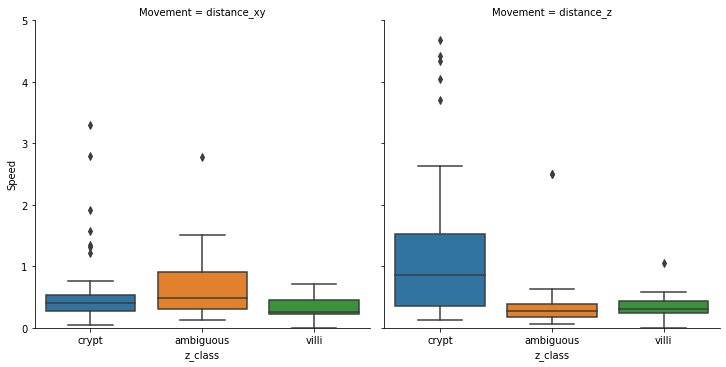

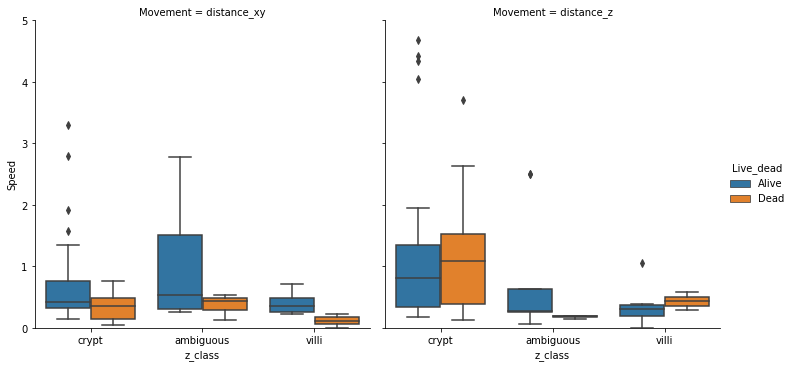

In [19]:
ylim = [0,5]
tmp = cell_df.groupby(['z_class','track_reindexed', 'Live_dead'])[['distance_xy', 'distance_z']].mean().reset_index()
tmp = pd.melt(tmp, id_vars=['z_class', 'Live_dead'], value_vars=['distance_xy', 'distance_z'], var_name='Movement', value_name='Speed')
sbn.catplot(data = tmp, y = 'Speed', x = 'z_class', kind = 'box', col='Movement', order=['crypt','ambiguous','villi'], facet_kws={'ylim': ylim})
sbn.catplot(data = tmp, y = 'Speed', x = 'z_class', hue = 'Live_dead', kind = 'box', col='Movement', order=['crypt','ambiguous','villi'], hue_order = ['Alive','Dead'], facet_kws={'ylim': ylim})

## Shown are averaged tracks with 95% CI

### Movement in XY

(0.0, 212.0)

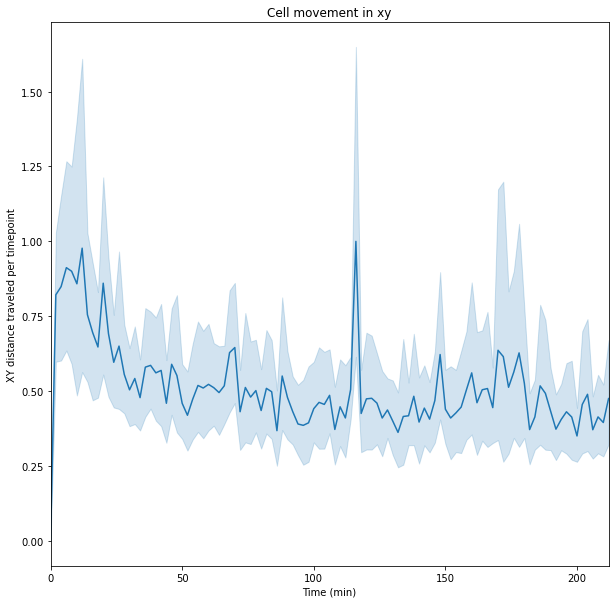

In [20]:
fig, ax = plt.subplots(figsize = (10,10))
sbn.lineplot(data = cell_df, x = 't', y = 'distance_xy')
#sbn.lineplot(data = cell_df_filtered_clipped, x = 't', y = 'distance_xyz', legend = 'brief')
plt.xlabel('Time (min)')
plt.ylabel('XY distance traveled per timepoint')
plt.title('Cell movement in xy')
plt.xticks(np.arange(0,max(cell_df['t']), 50))
plt.xlim([0,max(cell_df['t'])])
#plt.ylim([0,100])

(0.0, 212.0)

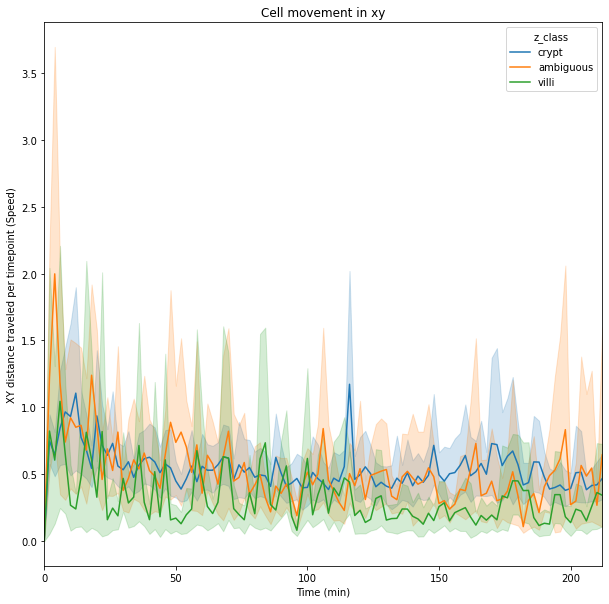

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
sbn.lineplot(data = cell_df, x = 't', y = 'distance_xy', hue = 'z_class')
#sbn.lineplot(data = cell_df_filtered_clipped, x = 't', y = 'distance_xyz', legend = 'brief')
plt.xlabel('Time (min)')
plt.ylabel('XY distance traveled per timepoint (Speed)')
plt.title('Cell movement in xy')
plt.xticks(np.arange(0,max(cell_df['t']), 50))
plt.xlim([0,max(cell_df['t'])])
#plt.ylim([0,100])

#plt.savefig(out_path + 'Cell movement in xy.pdf', format = 'pdf')

(0.0, 212.0)

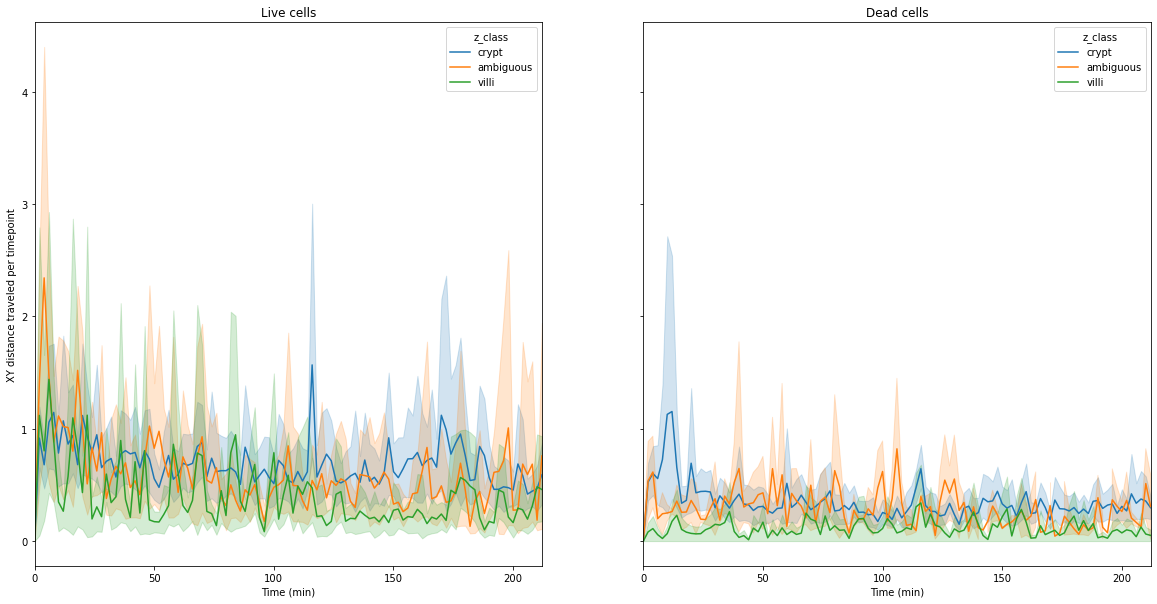

In [22]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,10), sharey = True)
sbn.lineplot(data = cell_df[cell_df['Live_dead']=='Alive'], x = 't', y = 'distance_xy', hue = 'z_class', ax = axes[0])
sbn.lineplot(data = cell_df[cell_df['Live_dead']=='Dead'], x = 't', y = 'distance_xy', hue = 'z_class', ax = axes[1])
#sbn.lineplot(data = cell_df_filtered_clipped, x = 't', y = 'distance_xyz', legend = 'brief')
axes[0].set_xlabel('Time (min)')
axes[1].set_xlabel('Time (min)')
axes[0].set_ylabel('XY distance traveled per timepoint')
axes[0].set_title('Live cells')
axes[1].set_title('Dead cells')
#plt.title('Cell movement in xy')
axes[0].set_xticks(np.arange(0,max(cell_df['t']), 50))
axes[1].set_xticks(np.arange(0,max(cell_df['t']), 50))
axes[0].set_xlim([0,max(cell_df['t'])])
axes[1].set_xlim([0,max(cell_df['t'])])
#plt.ylim([0,100])

#plt.savefig(out_path + 'Cell movement in xy.pdf', format = 'pdf')

### Movement in Z

(0.0, 212.0)

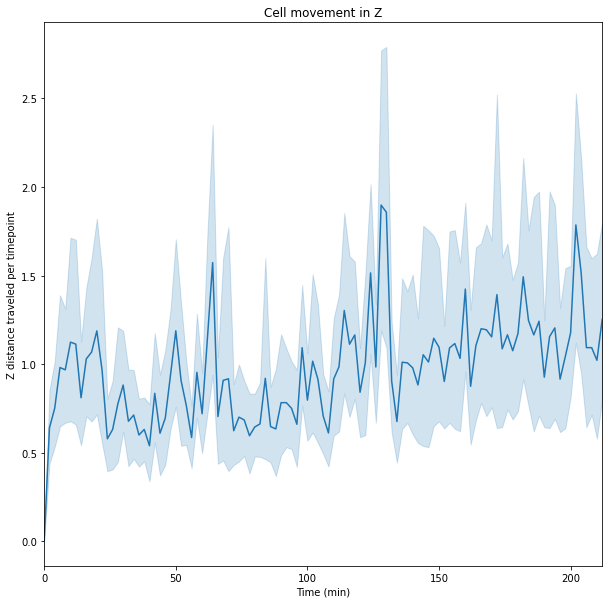

In [23]:
fig, ax = plt.subplots(figsize = (10,10))
sbn.lineplot(data = cell_df, x = 't', y = 'distance_z')
#sbn.lineplot(data = cell_df_filtered_clipped, x = 't', y = 'distance_xyz', legend = 'brief')
plt.xlabel('Time (min)')
plt.ylabel('Z distance traveled per timepoint')
plt.title('Cell movement in Z')
plt.xticks(np.arange(0,max(cell_df['t']), 50))
plt.xlim([0,max(cell_df['t'])])
#plt.ylim([0,100])

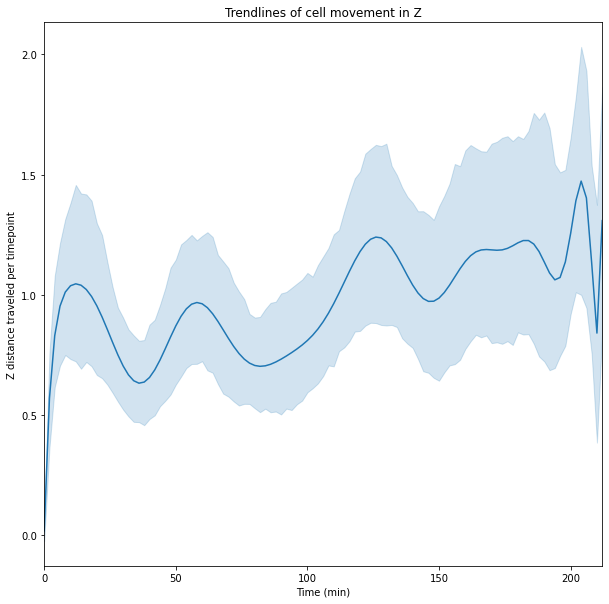

In [24]:
deg = 20
tmp_df = cell_df[['track_reindexed','t','distance_z']]

dist_fit = np.array([])

for track in sorted(set(tmp_df['track_reindexed'])):
    df = tmp_df[tmp_df['track_reindexed']==track].sort_values(by = 't')
    t = df['t'].values
    z = df['distance_z'].values
    z_fit = np.poly1d(np.polyfit(x = t, y = z, deg = deg))(t)
    dist_fit = np.append(dist_fit, z_fit)
    
tmp_df['distance_z_fit'] = dist_fit
clear_output()

fig, ax = plt.subplots(figsize = (10,10))
sbn.lineplot(data = tmp_df, x = 't', y = 'distance_z_fit')
#sbn.lineplot(data = cell_df_filtered_clipped, x = 't', y = 'distance_xyz', legend = 'brief')
plt.xlabel('Time (min)')
plt.ylabel('Z distance traveled per timepoint')
plt.title('Trendlines of cell movement in Z')
plt.xticks(np.arange(0,max(cell_df['t']), 50))
plt.xlim([0,max(cell_df['t'])])
#plt.ylim([0,100])
clear_output()

(0.0, 212.0)

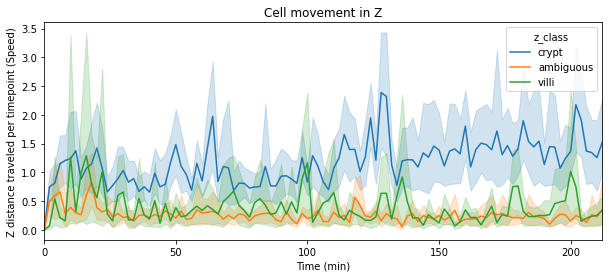

In [25]:
fig, ax = plt.subplots(figsize = (10,4))
sbn.lineplot(data = cell_df, x = 't', y = 'distance_z', hue = 'z_class')
#sbn.lineplot(data = cell_df_filtered_clipped, x = 't', y = 'distance_xyz', legend = 'brief')
plt.xlabel('Time (min)')
plt.ylabel('Z distance traveled per timepoint (Speed)')
plt.title('Cell movement in Z')
plt.xticks(np.arange(0,max(cell_df['t']), 50))
plt.xlim([0,max(cell_df['t'])])
#plt.ylim([0,100])

#plt.savefig(out_path + 'Cell movement in xy.pdf', format = 'pdf')

(0.0, 212.0)

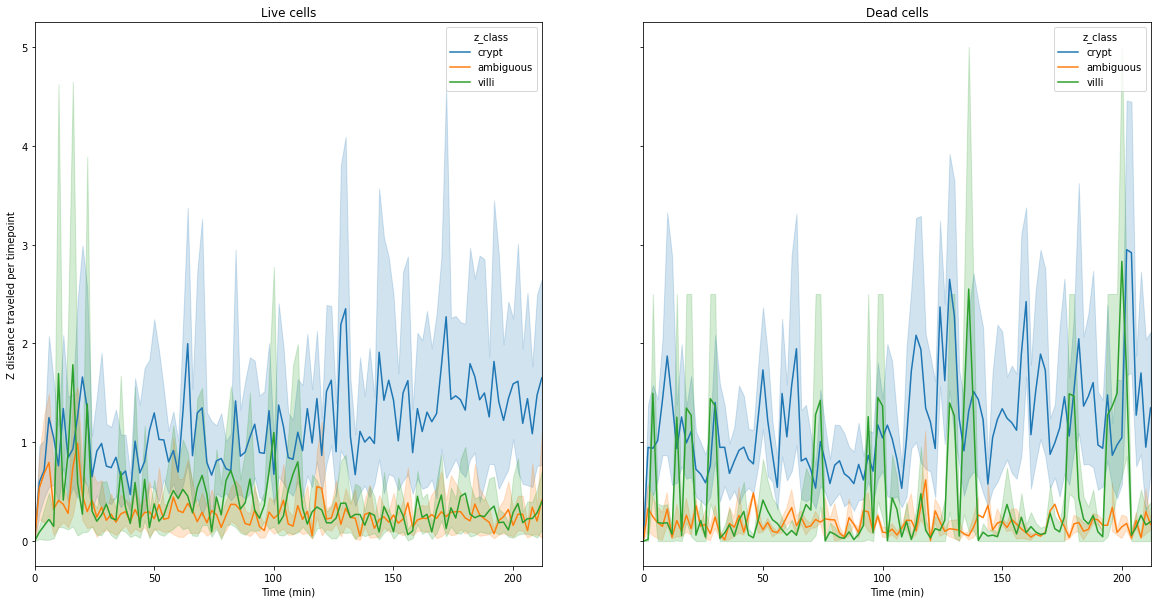

In [26]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,10), sharey = True)
sbn.lineplot(data = cell_df[cell_df['Live_dead']=='Alive'], x = 't', y = 'distance_z', hue = 'z_class', ax = axes[0])
sbn.lineplot(data = cell_df[cell_df['Live_dead']=='Dead'], x = 't', y = 'distance_z', hue = 'z_class', ax = axes[1])
#sbn.lineplot(data = cell_df_filtered_clipped, x = 't', y = 'distance_xyz', legend = 'brief')
axes[0].set_xlabel('Time (min)')
axes[1].set_xlabel('Time (min)')
axes[0].set_ylabel('Z distance traveled per timepoint')
axes[0].set_title('Live cells')
axes[1].set_title('Dead cells')
#plt.title('Cell movement in xy')
axes[0].set_xticks(np.arange(0,max(cell_df['t']), 50))
axes[1].set_xticks(np.arange(0,max(cell_df['t']), 50))
axes[0].set_xlim([0,max(cell_df['t'])])
axes[1].set_xlim([0,max(cell_df['t'])])
#plt.ylim([0,100])

#plt.savefig(out_path + 'Cell movement in xy.pdf', format = 'pdf')

### Movement in XYZ

(0.0, 212.0)

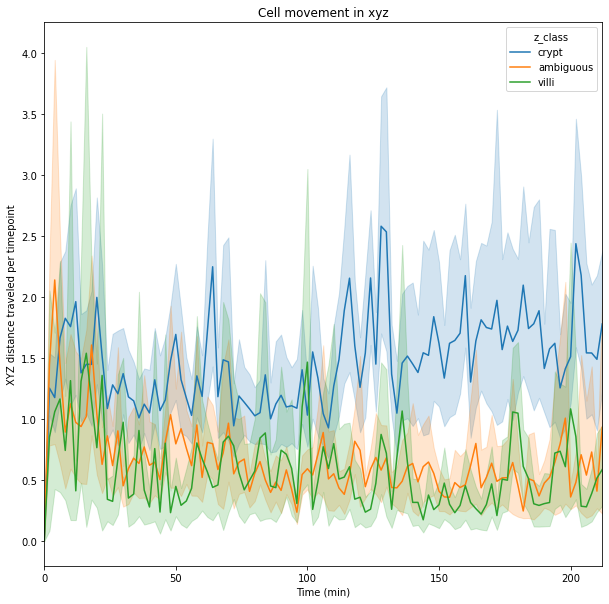

In [27]:
fig, ax = plt.subplots(figsize = (10,10))
sbn.lineplot(data = cell_df, x = 't', y = 'distance_xyz', hue = 'z_class')
#sbn.lineplot(data = cell_df_filtered_clipped, x = 't', y = 'distance_xyz', legend = 'brief')
plt.xlabel('Time (min)')
plt.ylabel('XYZ distance traveled per timepoint')
plt.title('Cell movement in xyz')
plt.xticks(np.arange(0,max(cell_df['t']), 50))
plt.xlim([0,max(cell_df['t'])])
#plt.ylim([0,100])

#plt.savefig(out_path + 'Cell movement in xyz.pdf', format = 'pdf')

(0.0, 212.0)

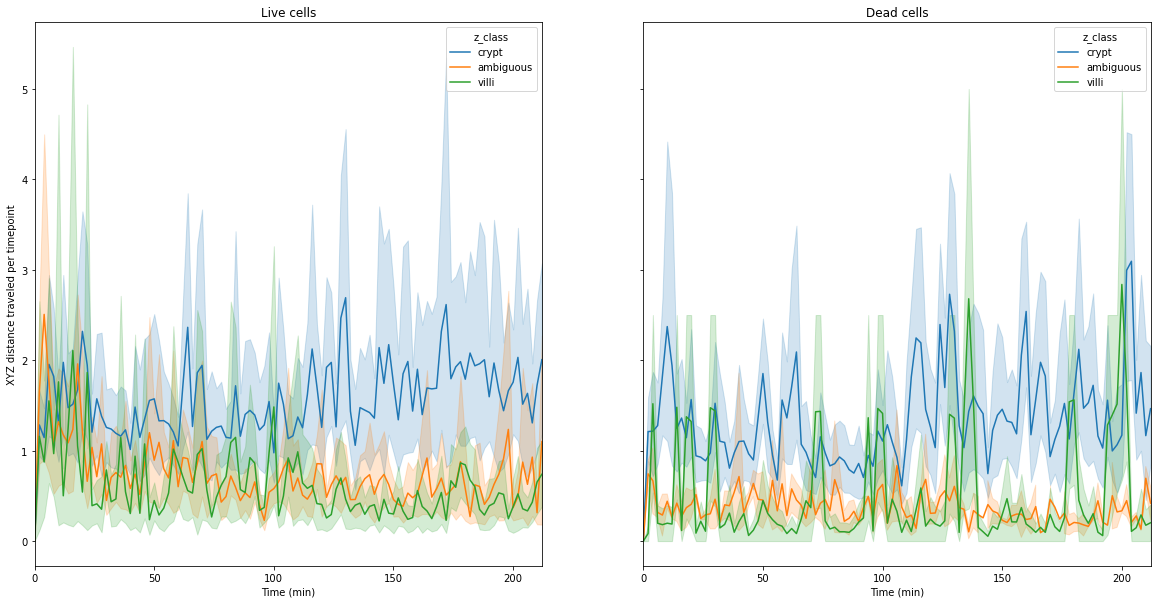

In [28]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,10), sharey = True)
sbn.lineplot(data = cell_df[cell_df['Live_dead']=='Alive'], x = 't', y = 'distance_xyz', hue = 'z_class', ax = axes[0])
sbn.lineplot(data = cell_df[cell_df['Live_dead']=='Dead'], x = 't', y = 'distance_xyz', hue = 'z_class', ax = axes[1])
#sbn.lineplot(data = cell_df_filtered_clipped, x = 't', y = 'distance_xyz', legend = 'brief')
axes[0].set_xlabel('Time (min)')
axes[1].set_xlabel('Time (min)')
axes[0].set_ylabel('XYZ distance traveled per timepoint')
axes[0].set_title('Live cells')
axes[1].set_title('Dead cells')
#plt.title('Cell movement in xy')
axes[0].set_xticks(np.arange(0,max(cell_df['t']), 50))
axes[1].set_xticks(np.arange(0,max(cell_df['t']), 50))
axes[0].set_xlim([0,max(cell_df['t'])])
axes[1].set_xlim([0,max(cell_df['t'])])

## Plot cumulative change

Text(0, 0.5, 'Cumulative change in z (um)')

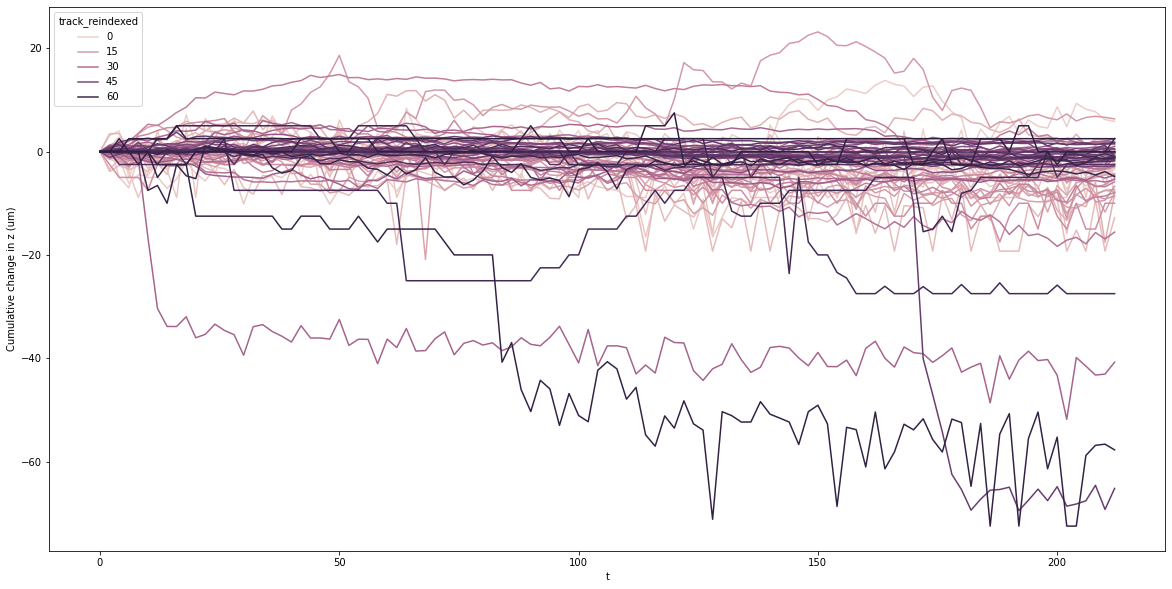

In [29]:
fig = plt.figure(figsize = (20,10))
g = sbn.lineplot(data = cell_df, y = 'difference_from_origin_z', x = 't', hue = 'track_reindexed')
#g.set_ylim([-100,5])
g.set_ylabel('Cumulative change in z (um)')
#fig.savefig(os.path.join(out_path + 'Cumulative change in z per track_corrected.pdf'), format = 'pdf')

Text(0.5, 1.0, 'Cumulative change in z, colored according to ending zone')

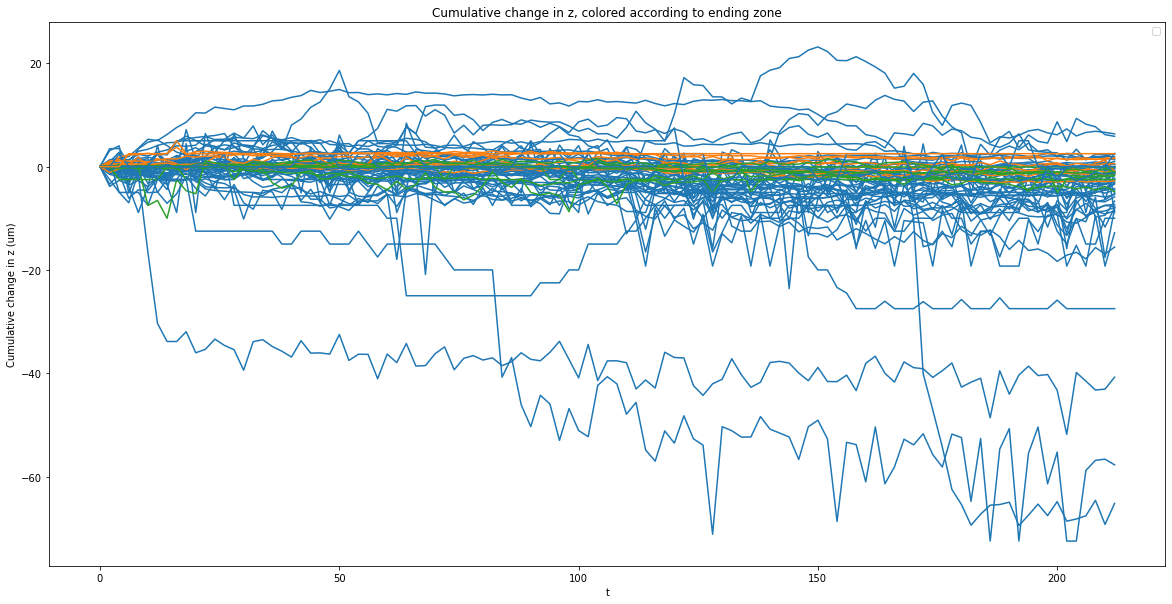

In [30]:
fig = plt.figure(figsize = (20,10))
g = sbn.lineplot(data = cell_df, y = 'difference_from_origin_z', x = 't', hue = 'track_reindexed', palette = track_ending_color_dict)
#g.set_ylim([-100,5])
g.legend('')
g.set_ylabel('Cumulative change in z (um)')
g.set_title('Cumulative change in z, colored according to ending zone')

Dashed lines in next plot signify dead cells

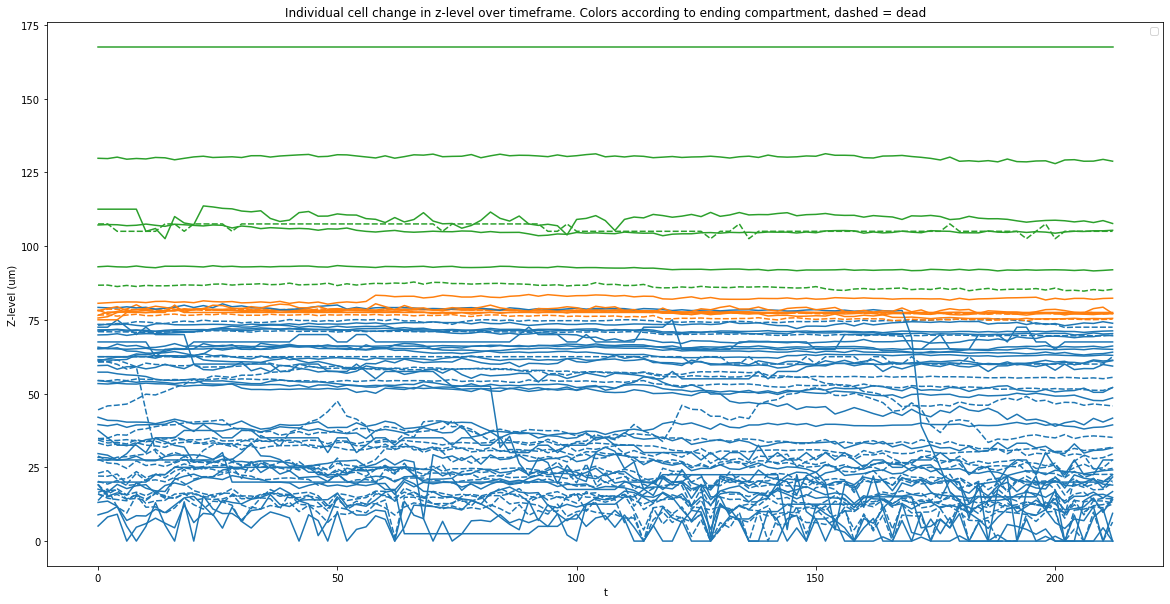

In [31]:
fig = plt.figure(figsize = (20,10))
g = sbn.lineplot(data = cell_df, y = 'z', x = 't', hue = 'track_reindexed', palette = track_ending_color_dict, style='Live_dead')
g.legend('')
g.set_ylabel('Z-level (um)')
g.set_title('Individual cell change in z-level over timeframe. Colors according to ending compartment, dashed = dead')
clear_output(wait = True)

### Cumulative xy-change

<AxesSubplot:xlabel='x', ylabel='y'>

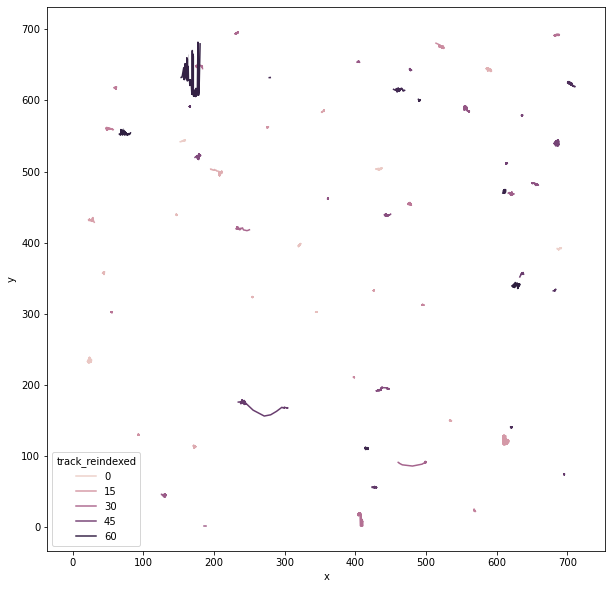

In [32]:
plt.figure(figsize = (10,10))
sbn.lineplot(data = cell_df.sort_values(by = 't'), x = 'x', y = 'y',
             hue = 'track_reindexed')

### 3D plot of xy-distance traveled over time, separated by z-level

Text(0.5, 0, 'z')

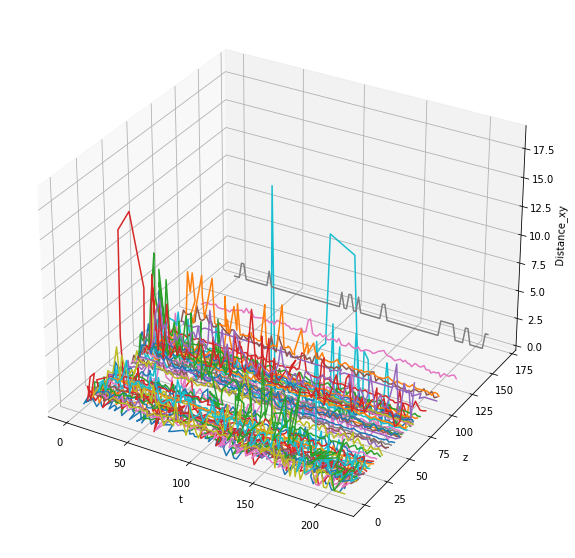

In [33]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

for track in sorted(set(cell_df['track_reindexed'])):
    tmp = cell_df[cell_df['track_reindexed'] == track]
    ax.plot(xs = tmp['t'], ys=tmp['z'], zs=tmp['distance_xy'])
    
ax.set_xlabel('t')
ax.set_zlabel('Distance_xy')
ax.set_ylabel('z')

## Plot speeds with only live cells

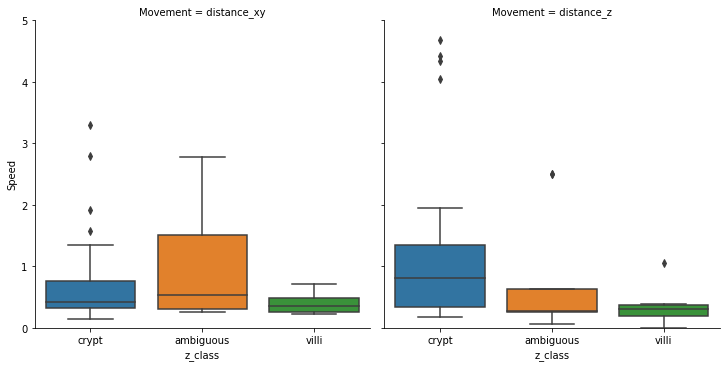

In [34]:
ylim = [0,5]
tmp = cell_df[cell_df['Live_dead']=='Alive'].groupby(['z_class','track_reindexed', 'Live_dead'])[['distance_xy', 'distance_z']].mean().reset_index()
tmp = pd.melt(tmp, id_vars=['z_class', 'Live_dead'], value_vars=['distance_xy', 'distance_z'], var_name='Movement', value_name='Speed')
sbn.catplot(data = tmp, y = 'Speed', x = 'z_class', kind = 'box', col='Movement', order=['crypt','ambiguous','villi'], facet_kws={'ylim': ylim})

# Cell movement from villi

In [35]:
class_dict = {'villi': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              'crypt': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              'ambiguous': (1.0, 0.4980392156862745, 0.054901960784313725)}

track_ending_z_dict = {}
track_ending_color_dict = {}
track_starting_color_dict = {}
for track in set(cell_df['track_reindexed']):
    val_end = cell_df[cell_df['track_reindexed']==track]['z_class'].iloc[-1]
    val_start = cell_df[cell_df['track_reindexed']==track]['z_class'].iloc[0]
    track_ending_z_dict[track] = val_end
    track_ending_color_dict[track] = class_dict[val_end]
    track_starting_color_dict[track] = class_dict[val_start]

## Find origin and end z_class

In [36]:
#Z-class at the beginnig of tracking
tmp_df = cell_df[cell_df['t'] == cell_df['origin_t']][['track_reindexed', 'z_class']].set_index('track_reindexed')
cell_df['origin_class'] = [tmp_df['z_class'].loc[track] for track in cell_df['track_reindexed']]

#Z-class at the end of tracking
tmp_df = cell_df[cell_df['t'] == cell_df['end_t']][['track_reindexed', 'z_class']].set_index('track_reindexed')
cell_df['end_class'] = [tmp_df['z_class'].loc[track] for track in cell_df['track_reindexed']]

## Plot cell movement in Z

In [37]:
tmp_df = cell_df[cell_df['origin_class'] != cell_df['end_class']]
tracks = set(tmp_df['track_reindexed'])
tmp_df = cell_df[cell_df['track_reindexed'].isin(tracks)]

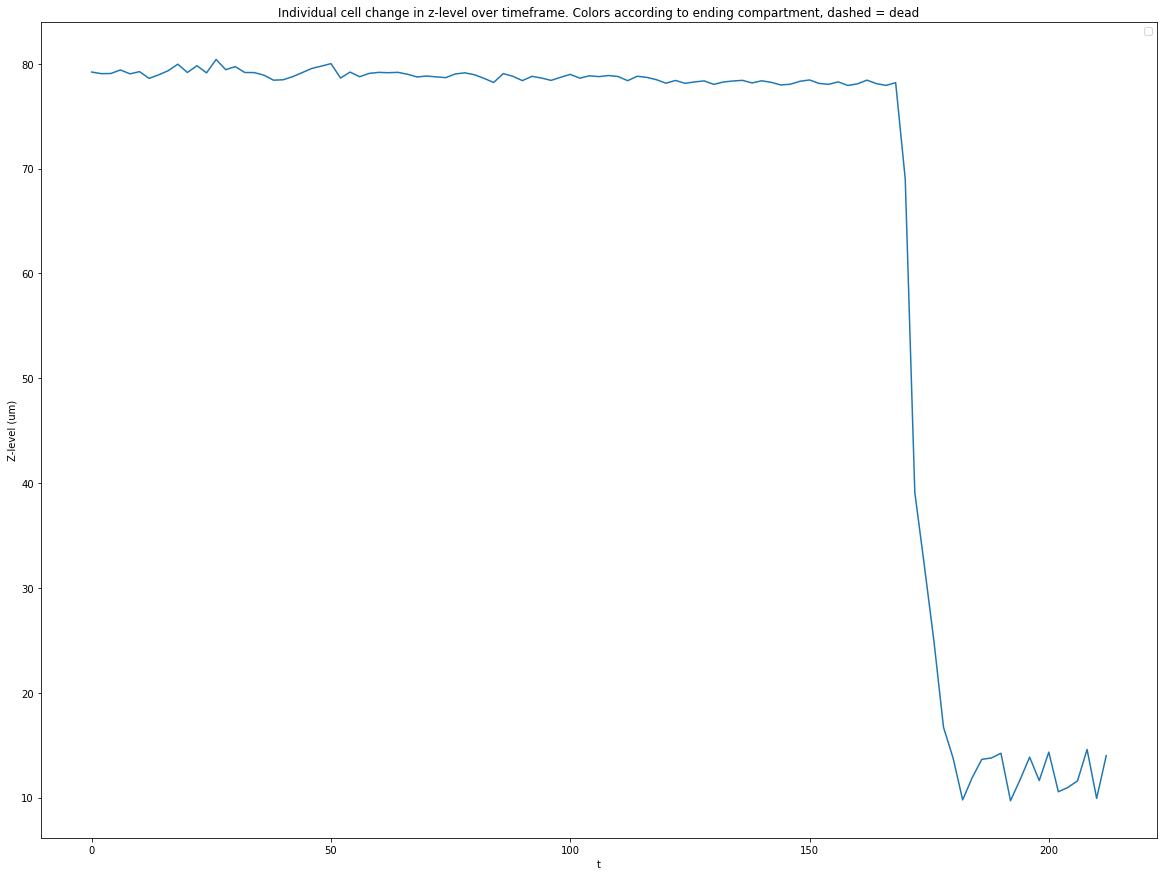

In [38]:
fig = plt.figure(figsize = (20,15))
g = sbn.lineplot(data = tmp_df, y = 'z', x = 't', hue = 'track_reindexed', palette = track_ending_color_dict, style='Live_dead')
g.legend('')
g.set_ylabel('Z-level (um)')
g.set_title('Individual cell change in z-level over timeframe. Colors according to ending compartment, dashed = dead')
clear_output(wait = True)

# Plot total z-movement of cells

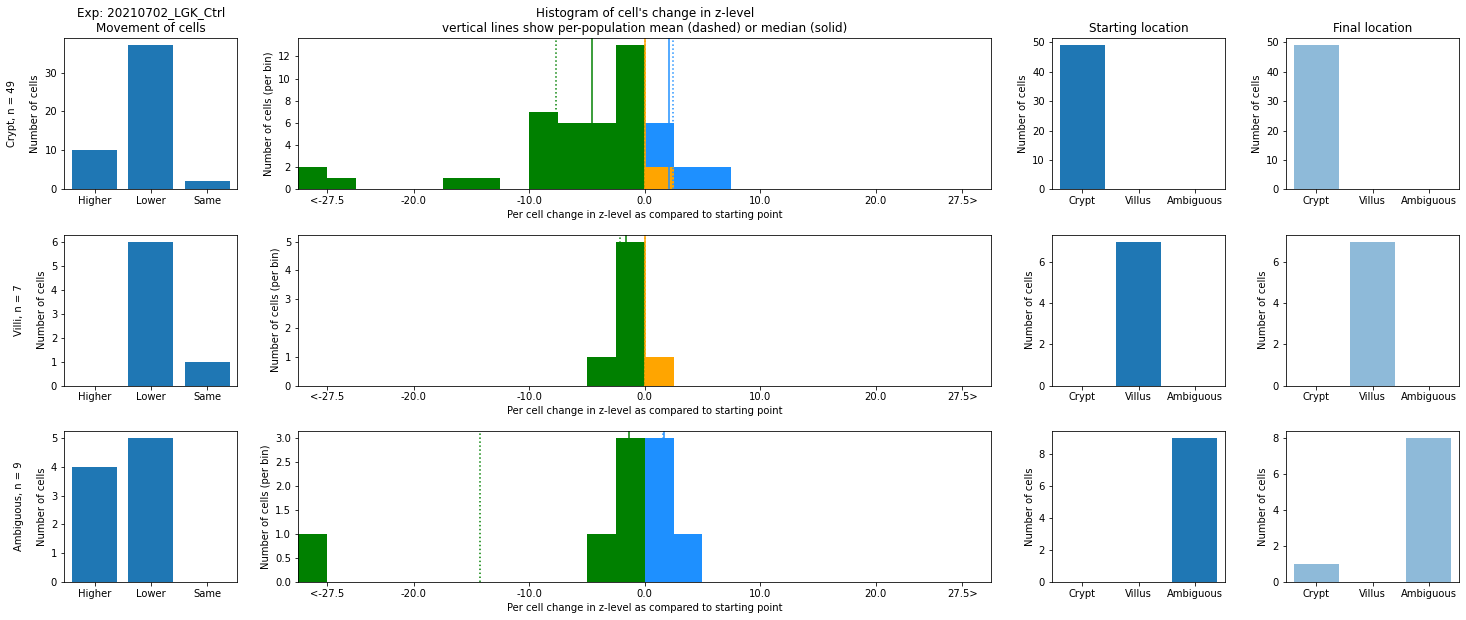

In [39]:
step = 2.5
rng = 27.5
b = [-1000]; b.extend(np.arange(-rng, rng+step, step)); b.extend([1000])

axes = plot_cell_z_movements(cell_df, nrows = 3, ncols = 4, plot_percentage = False, hist_xlim = True, 
                      hist_bins = b , return_axes = True, experiment_name=exp_name)

[axes[r, 1].set_xlim([-rng-step, rng+step]) for r in [0,1,2]]
[axes[r, 1].set_xticks(np.append(np.append(axes[r,1].get_xticks()[0]+step, axes[r,1].get_xticks()[1:-1]), axes[r,1].get_xticks()[-1]-step)) for r in [0,1,2]]
[axes[r, 1].set_xticklabels(np.append(np.append('<{}'.format(axes[r,1].get_xticks()[0]), axes[r,1].get_xticks()[1:-1]), '{}>'.format(axes[r,1].get_xticks()[-1]))) for r in [0,1,2]]
clear_output()

In [40]:
tmp_dict = {}
tmp_dict_fit = {}
for track in np.unique(cell_df['track_reindexed'].values):
    zs = cell_df[cell_df['track_reindexed']==track].sort_values(by = 't')[['t','z']]
    p = np.poly1d(np.polyfit(x = zs['t'].values, y = zs['z'].values, deg = 9))(zs['t'].values)
    tmp_dict[track] = zs['z'].values[-1] - zs['z'].values[0]
    tmp_dict_fit[track] = p[-1]-p[0]

## Raw values

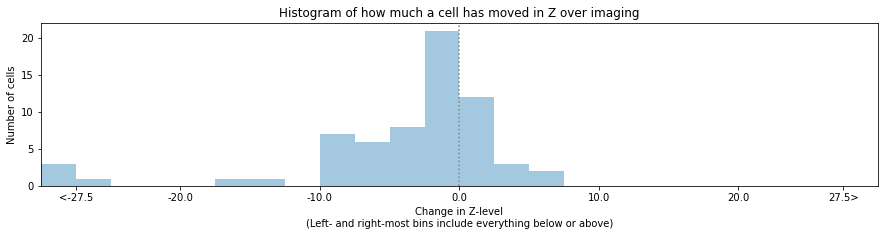

In [41]:
step = 2.5
rng = 27.5
b = [-1000]; b.extend(np.arange(-rng, rng+step, step)); b.extend([1000])

fig, ax = plt.subplots(figsize =(15, 3))
sbn.distplot(a = list(tmp_dict.values()), kde = False, ax = ax, bins = b)
ax.axvline(0, ls = ':', c = 'grey')
ax.set_xlim([-rng-step, rng+step])
#ax.set_xticks(b[2:-1:2])
ax.set_xticks(np.append(np.append(ax.get_xticks()[0]+step, ax.get_xticks()[1:-1]), ax.get_xticks()[-1]-step))
ax.set_xticklabels(np.append(np.append('<{}'.format(ax.get_xticks()[0]), ax.get_xticks()[1:-1]), '{}>'.format(ax.get_xticks()[-1])))
ax.set_title('Histogram of how much a cell has moved in Z over imaging')
ax.set_ylabel('Number of cells')
ax.set_xlabel('Change in Z-level\n(Left- and right-most bins include everything below or above)')
clear_output()

## Fitted values

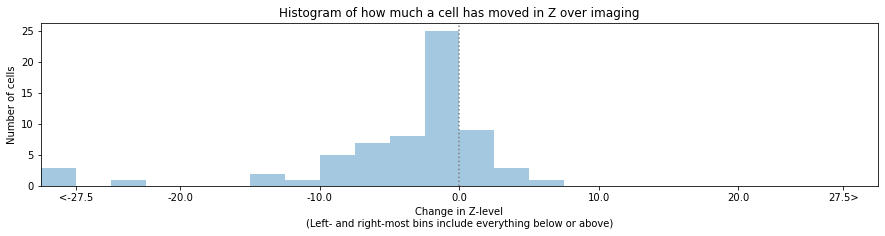

In [42]:
step = 2.5
rng = 27.5
b = [-1000]; b.extend(np.arange(-rng, rng+step, step)); b.extend([1000])

fig, ax = plt.subplots(figsize =(15, 3))
sbn.distplot(a = list(tmp_dict_fit.values()), kde = False, ax = ax, bins = b)
ax.axvline(0, ls = ':', c = 'grey')
ax.set_xlim([-rng-step, rng+step])
#ax.set_xticks(b[2:-1:2])
ax.set_xticks(np.append(np.append(ax.get_xticks()[0]+step, ax.get_xticks()[1:-1]), ax.get_xticks()[-1]-step))
ax.set_xticklabels(np.append(np.append('<{}'.format(ax.get_xticks()[0]), ax.get_xticks()[1:-1]), '{}>'.format(ax.get_xticks()[-1])))
ax.set_title('Histogram of how much a cell has moved in Z over imaging')
ax.set_ylabel('Number of cells')
ax.set_xlabel('Change in Z-level\n(Left- and right-most bins include everything below or above)')
clear_output()

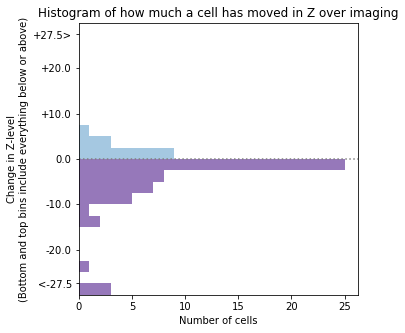

In [43]:
step = 2.5
rng = 27.5
b = [-1000]; b.extend(np.arange(-rng, rng+step, step)); b.extend([1000])

fig, ax = plt.subplots(figsize =(5, 5))
a = np.array(list(tmp_dict_fit.values()))
sbn.distplot(a = a, kde = False, ax = ax, bins = b, vertical  = True)
sbn.distplot(a = a[a<0], kde = False, ax = ax, bins = b, vertical  = True, color = 'purple')
ax.axhline(0, ls = ':', c = 'grey')
ax.set_ylim([-rng-step, rng+step])
#ax.set_xticks(b[2:-1:2])
ax.set_yticks(np.append(np.append(ax.get_yticks()[0]+step, ax.get_yticks()[1:-1]), ax.get_yticks()[-1]-step))
ax.set_yticklabels(np.append(np.append('<{}'.format(ax.get_yticks()[0]), ['+{}'.format(x) if x>0 else x for x in ax.get_yticks()[1:-1]]), '+{}>'.format(ax.get_yticks()[-1])))
ax.set_title('Histogram of how much a cell has moved in Z over imaging')
ax.set_xlabel('Number of cells')
ax.set_ylabel('Change in Z-level\n(Bottom and top bins include everything below or above)')
clear_output()

In [44]:
cell_df.sort_values(by = ['track_reindexed', 't']).to_csv(os.path.join(out_path, exp_name+'.csv'))